In [1]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
%matplotlib inline
sns.set_style("whitegrid")
np.random.seed(697)

Using TensorFlow backend.


In [18]:
#Import data
dfOriginal = pd.read_csv('data/train_sample.csv', header = 0)

In [19]:
df = dfOriginal.copy()

In [5]:
#Check num of cases in label 
print(df.is_attributed.value_counts()) #very imbalanced data set

0    99773
1      227
Name: is_attributed, dtype: int64


In [15]:
pal = sns.color_palette()

/usr/local/lib/python3.6/dist-packages/matplotlib/scale.py:114: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


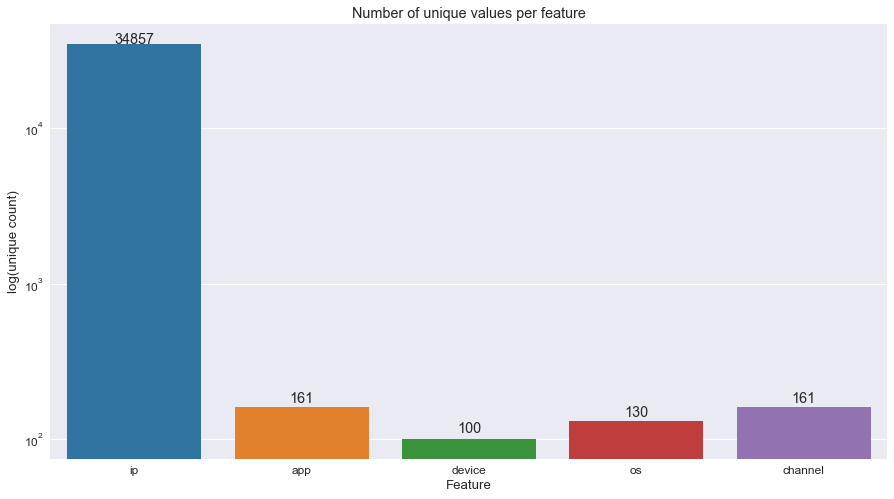

In [20]:
plt.figure(figsize=(15, 8))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(df[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, palette=pal, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 
# for col, uniq in zip(cols, uniques):
#     ax.text(col, uniq, uniq, color='black', ha="center")

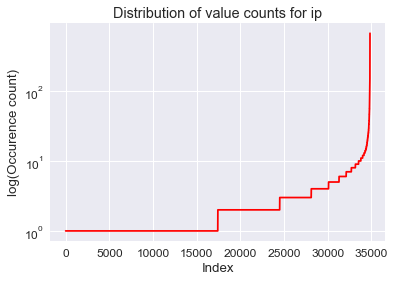

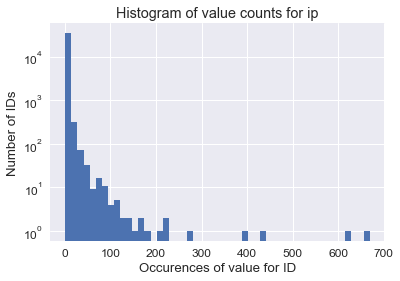

Variable 'ip': | Unique values: 34857 | Count of most common: 669 | Count of least common: 1 | count>10: 3.02% | count>100: 0.06% | count>1000: 0.0%


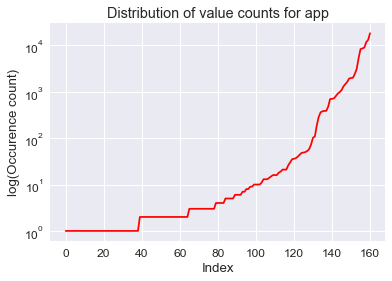

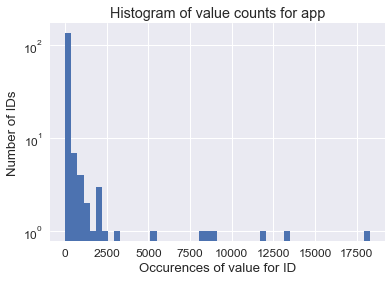

Variable 'app': | Unique values: 161 | Count of most common: 18279 | Count of least common: 1 | count>10: 36.02% | count>100: 19.25% | count>1000: 9.94%


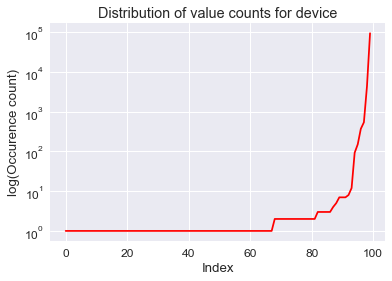

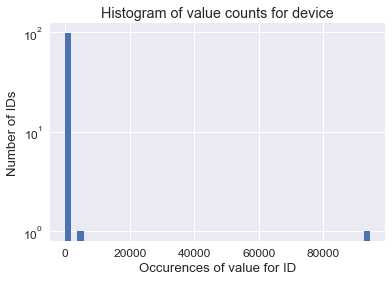

Variable 'device': | Unique values: 100 | Count of most common: 94338 | Count of least common: 1 | count>10: 7.0% | count>100: 5.0% | count>1000: 2.0%


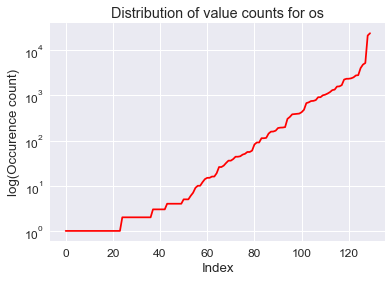

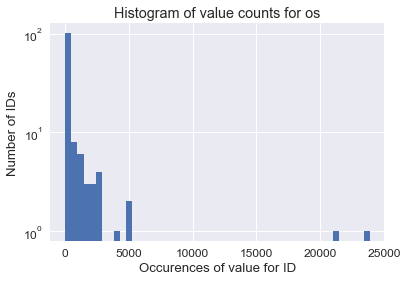

Variable 'os': | Unique values: 130 | Count of most common: 23870 | Count of least common: 1 | count>10: 55.38% | count>100: 36.15% | count>1000: 16.15%


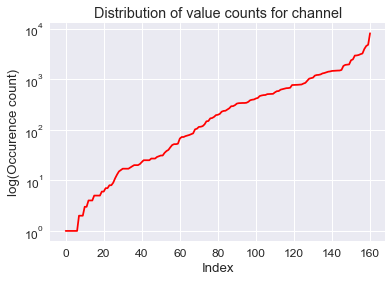

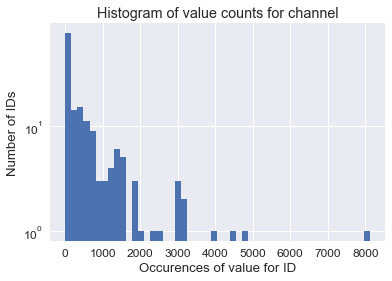

Variable 'channel': | Unique values: 161 | Count of most common: 8114 | Count of least common: 1 | count>10: 83.85% | count>100: 57.76% | count>1000: 20.5%


In [21]:
for col, uniq in zip(cols, uniques):
    counts = df[col].value_counts()

    sorted_counts = np.sort(counts.values)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    line, = ax.plot(sorted_counts, color='red')
    ax.set_yscale('log')
    plt.title("Distribution of value counts for {}".format(col))
    plt.ylabel('log(Occurence count)')
    plt.xlabel('Index')
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.hist(sorted_counts, bins=50)
    ax.set_yscale('log', nonposy='clip')
    plt.title("Histogram of value counts for {}".format(col))
    plt.ylabel('Number of IDs')
    plt.xlabel('Occurences of value for ID')
    plt.show()
    
    max_count = np.max(counts)
    min_count = np.min(counts)
    gt = [10, 100, 1000]
    prop_gt = []
    for value in gt:
        prop_gt.append(round((counts > value).mean()*100, 2))
    print("Variable '{}': | Unique values: {} | Count of most common: {} | Count of least common: {} | count>10: {}% | count>100: {}% | count>1000: {}%".format(col, uniq, max_count, min_count, *prop_gt))


In [22]:
df = dfOriginal.copy()

In [23]:
#convert to date/time
df['click_time'] = pd.to_datetime(df['click_time'])
df['attributed_time'] = pd.to_datetime(df['attributed_time'])

#extract hour as a feature
df['click_hour']=df['click_time'].dt.hour

In [24]:
X = df
Y = X['is_attributed']

In [25]:
def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['col1', 'col2'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax


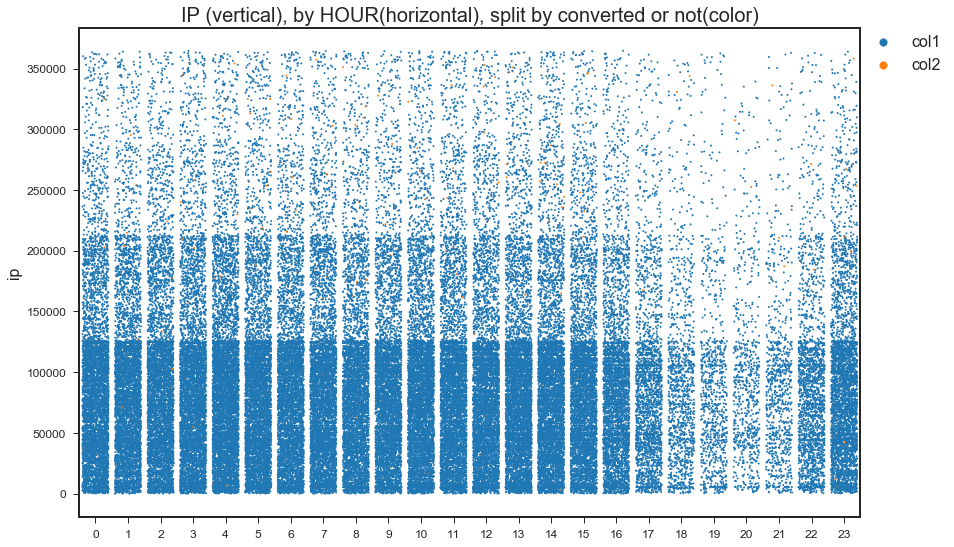

In [26]:
ax = plotStrip(X.click_hour, X.ip, Y)
ax.set_ylabel('ip', size = 16)
ax.set_title('IP (vertical), by HOUR(horizontal), split by converted or not(color)', size = 20);

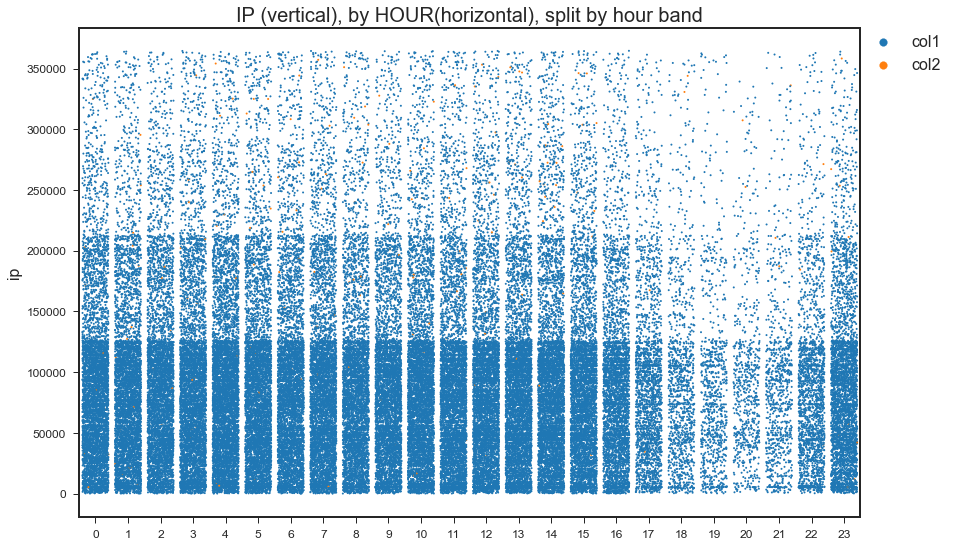

In [27]:
ax = plotStrip(X.click_hour, X.ip, Y)
ax.set_ylabel('ip', size = 16)
ax.set_title('IP (vertical), by HOUR(horizontal), split by hour band', size = 20);

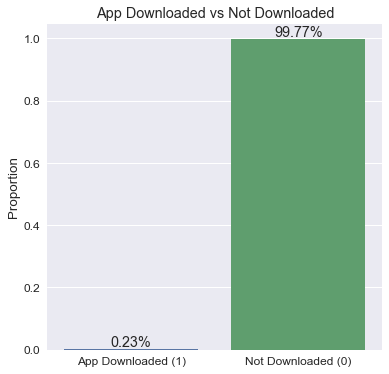

In [29]:
plt.figure(figsize=(6,6))
#sns.set(font_scale=1.2)
mean = (df.is_attributed.values == 1).mean()
ax = sns.barplot(['App Downloaded (1)', 'Not Downloaded (0)'], [mean, 1-mean])
ax.set(ylabel='Proportion', title='App Downloaded vs Not Downloaded')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

In [30]:
#convert 'is_attributed' back to numeric for proportion calculations
df['is_attributed']=df['is_attributed'].astype(int)

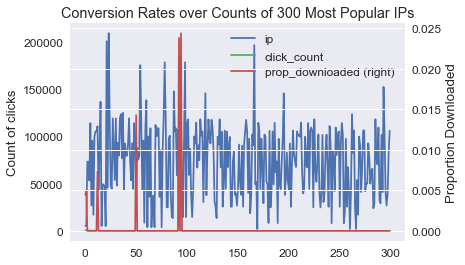

In [32]:
proportion = df[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = df[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='ip', how='left')
merge.columns = ['ip', 'click_count', 'prop_downloaded']

ax = merge[:300].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 300 Most Popular IPs')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()


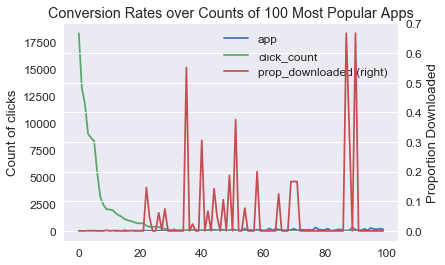

In [33]:
proportion = df[['app', 'is_attributed']].groupby('app', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = df[['app', 'is_attributed']].groupby('app', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='app', how='left')
merge.columns = ['app', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

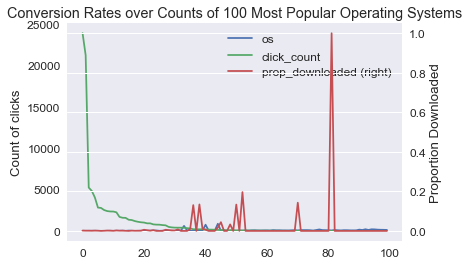

In [34]:
proportion = df[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = df[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Operating Systems')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

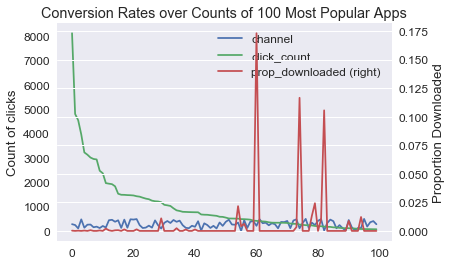

In [35]:
proportion = df[['channel', 'is_attributed']].groupby('channel', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = df[['channel', 'is_attributed']].groupby('channel', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='channel', how='left')
merge.columns = ['channel', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

In [37]:
df.head(7)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_hour
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,9
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,13
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0,18
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0,4
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0,9
5,93663,3,1,17,115,2017-11-09 01:22:13,NaT,0,1
6,17059,1,1,17,135,2017-11-09 01:17:58,NaT,0,1


In [49]:
#convert click_time and attributed_time to time series
df['click_time'] = pd.to_datetime(df['click_time'])
df['attributed_time'] = pd.to_datetime(df['attributed_time'])

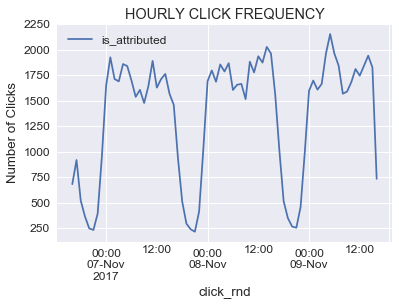

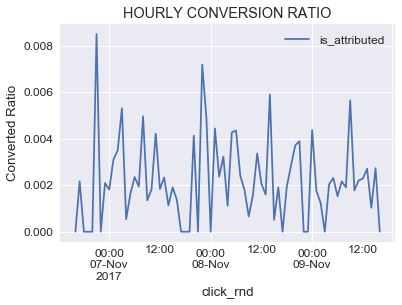

In [39]:
#round the time to nearest hour
df['click_rnd']=df['click_time'].dt.round('H')  

#check for hourly patterns
df[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).count().plot()
plt.title('HOURLY CLICK FREQUENCY');
plt.ylabel('Number of Clicks');

df[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).mean().plot()
plt.title('HOURLY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

In [51]:
#extract hour as a feature
df['click_hour']=df['click_time'].dt.hour

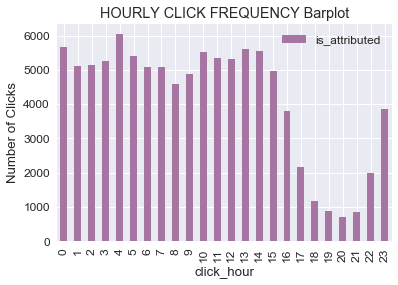

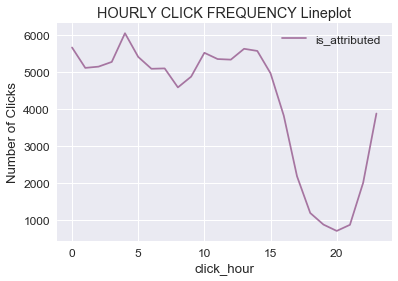

In [40]:
df[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(kind='bar', color='#a675a1')
plt.title('HOURLY CLICK FREQUENCY Barplot');
plt.ylabel('Number of Clicks');

df[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(color='#a675a1')
plt.title('HOURLY CLICK FREQUENCY Lineplot');
plt.ylabel('Number of Clicks');

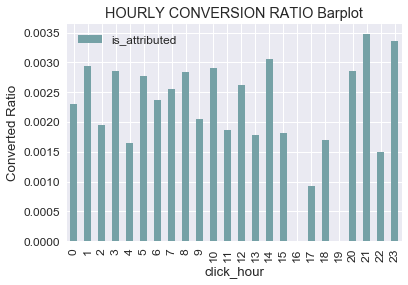

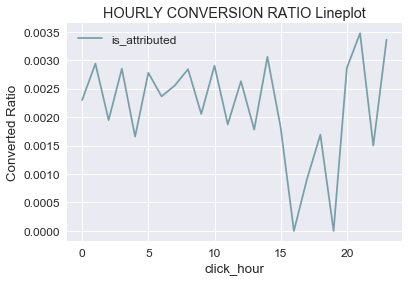

In [41]:
df[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot(kind='bar', color='#75a1a6')
plt.title('HOURLY CONVERSION RATIO Barplot');
plt.ylabel('Converted Ratio');

df[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot( color='#75a1a6')
plt.title('HOURLY CONVERSION RATIO Lineplot');
plt.ylabel('Converted Ratio');